In [1]:
import scipy.io
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import xarray as xr
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from scipy.stats import linregress
import scipy.stats as stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Define metadata for the time series variables
var_list_lsm  = [
    ("TWS_tavg", "terrestrial water storage", "mm"),
    ("Swnet_tavg", "net downward shortwave radiation", "W m-2"),
    ("Lwnet_tavg", "net downward longwave radiation", "W m-2"),
    ("Qle_tavg", "latent heat flux", "W m-2"),
    ("Qh_tavg", "sensible heat flux", "W m-2"),
    ("Qg_tavg", "soil heat flux", "W m-2"),
    ("EF_tavg", "evaporative fraction", "-"),
    ("Evap_tavg", "total evapotranspiration", "kg m-2 s-1"),
    ("Qs_tavg", "surface runoff", "kg m-2 s-1"),
    ("Qsb_tavg", "subsurface runoff", "kg m-2 s-1"),
    ("AvgSurfT_tavg", "surface temperature", "K"),
    ("SoilMoist01_tavg", "soil moisture content 0-10 cm", "m3 m-3"),
    ("SoilMoist02_tavg", "soil moisture content 10-40 cm", "m3 m-3"),
    ("SoilMoist03_tavg", "soil moisture content 40-100 cm", "m3 m-3"),
    ("SoilMoist04_tavg", "soil moisture content 100-200 cm", "m3 m-3"),
    ("SoilTemp01_tavg", "soil temperature 0-10 cm", "K"),
    ("SoilTemp02_tavg", "soil temperature 10-40 cm", "K"),
    ("SoilTemp03_tavg", "soil temperature 40-100 cm", "K"),
    ("SoilTemp04_tavg", "soil temperature 100-200 cm", "K"),
    ("TVeg_tavg", "vegetation transpiration", "kg m-2 s-1"),
    ("ESoil_tavg", "bare soil evaporation", "kg m-2 s-1"),
    ("WaterTableD_inst", "water table depth", "m"),
    ("GWS_tavg", "ground water storage", "mm"),
    ("GPP_tavg", "gross primary production", "g m-2 s-1"),
    ("NPP_tavg", "net primary productivity", "g m-2 s-1"),
    ("NEE_tavg", "net ecosystem exchange", "g m-2 s-1"),
    ("Rainf_f_tavg", "rainfall flux", "kg m-2 s-1"),
    ("Tair_f_tavg", "air temperature", "K"),
    ("LAI_tavg", "leaf area index", "m2 m-2"),
]

directory_path = r"D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov"

# Use glob to find all .mat files in the directory
mat_files = glob.glob(os.path.join(directory_path, "*.mat"))

# Initialize lists to store data
all_time_series = []
all_dates = []
all_basin_names = []
file_names = []

# Loop through each .mat file
for mat_file in mat_files:
    try:
        # Load the .mat file
        data = scipy.io.loadmat(mat_file, struct_as_record=False)

        # Extract data with error handling
        time_series = data.get('tss')
        date = data.get('date')
        basin_name = data.get('basin_name')

        # Skip files with missing data
        if time_series is None or date is None or basin_name is None:
            print(f"Warning: Missing variables in file {mat_file}. Skipping.")
            continue

        # Store data
        all_time_series.append(time_series)
        all_dates.append(date)
        all_basin_names.append(basin_name)
        file_names.append(os.path.basename(mat_file))

        print(f"Successfully loaded: {mat_file}")

    except Exception as e:
        print(f"Error loading file {mat_file}: {e}")

Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\AvgSurfT_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\EF_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\ESoil_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\Evap_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\GPP_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\GWS_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\LAI_tavg_monthly_195801_202407.mat
Successfully loaded: D:\Dom_Work\A

In [2]:
# Load the shapefile using GeoPandas
shapefile_path = r"D:\Dom_Work\A_Work\Work\01_AIT\02_Environmental Indice\time_series_province\prov\shapefile\THA_adm1.shp"
gdf = gpd.read_file(shapefile_path)

# Convert shapefile basin names to a list
shapefile_basin_names = gdf['NAME_1'].unique().tolist()

basin_names = [name_array[0][0] for name_array in basin_name]
# Map basin names to geometries from shapefile
geometry_mapping = {}
for area in set(basin_names):
    if area in shapefile_basin_names:
        # Retrieve geometry for the corresponding basin name
        geometry_mapping[area] = gdf.loc[gdf['NAME_1'] == area].geometry.values[0]
    else:
        print(f"Warning: Basin '{area}' not found in the shapefile.")

# Check a few samples of basin names with their corresponding geometry
print("\nSample of basin names and their geometries:")
sample_size = 5  # Number of samples to check
sample_mapping = list(geometry_mapping.items())[:sample_size]
for area, geometry in sample_mapping:
    print(f"Basin Name: {area}, Geometry Type: {geometry.geom_type}")

# Create an empty dictionary to store time series data for each variable
data_dict = {}

# Define variable names
variables = [fname.split("_tavg")[0] for fname in file_names]
# Loop over the variable names and their corresponding time series data
for i, var_name in enumerate(variables):
    # Assign the time series data to the corresponding variable name
    data_dict[var_name] = all_time_series[i]

# Check the shape of the time series for each variable
for var_name, time_series in data_dict.items():
    print(f"Variable: {var_name}, Shape: {time_series.shape}")
    
# Convert 'date' to datetime format (year and month)
for i, date in enumerate(all_dates):
    all_dates[i] = pd.to_datetime([f'{int(y)}-{int(m)}-01' for y, m in date])
# Create an empty xarray.Dataset
dataset = xr.Dataset()

# Loop through each variable in data_dict and add it to the Dataset
for var_name, time_series in data_dict.items():
    # Create a DataArray for each variable (e.g., 'AvgSurfT', etc.)
    data_array = xr.DataArray(
        data=time_series,  # Actual data (shape: time x area)
        dims=["time", "area"],  # Define dimensions: time and area
        coords={
            "time": all_dates[0],  # Time coordinate
            "area": basin_names,  # Basin names as area
            "geometry": ("area", [geometry_mapping.get(area, np.nan) for area in basin_names])  # Map geometry
        },
        name=var_name  # Name of the variable (e.g., 'AvgSurfT')
    )
    
    # Add the DataArray to the dataset
    dataset[var_name] = data_array

# Display the created xarray dataset structure
print("\nCreated xarray.Dataset:")
print(dataset)


Sample of basin names and their geometries:
Basin Name: Yasothon, Geometry Type: Polygon
Basin Name: Phra Nakhon Si Ayutthaya, Geometry Type: Polygon
Basin Name: Ranong, Geometry Type: MultiPolygon
Basin Name: Nakhon Phanom, Geometry Type: Polygon
Basin Name: Maha Sarakham, Geometry Type: Polygon
Variable: AvgSurfT, Shape: (799, 78)
Variable: EF, Shape: (799, 78)
Variable: ESoil, Shape: (799, 78)
Variable: Evap, Shape: (799, 78)
Variable: GPP, Shape: (799, 78)
Variable: GWS, Shape: (799, 78)
Variable: LAI, Shape: (799, 78)
Variable: Lwnet, Shape: (799, 78)
Variable: NEE, Shape: (799, 78)
Variable: NPP, Shape: (799, 78)
Variable: Qg, Shape: (799, 78)
Variable: Qh, Shape: (799, 78)
Variable: Qle, Shape: (799, 78)
Variable: Qsb, Shape: (799, 78)
Variable: Qs, Shape: (799, 78)
Variable: Rainf_f, Shape: (799, 78)
Variable: SoilMoist01, Shape: (799, 78)
Variable: SoilMoist02, Shape: (799, 78)
Variable: SoilMoist03, Shape: (799, 78)
Variable: SoilMoist04, Shape: (799, 78)
Variable: SoilTemp0

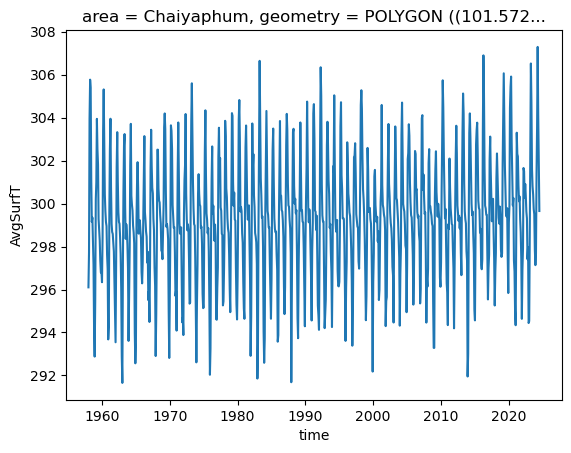

In [45]:
dataset['AvgSurfT'].sel(area = 'Chaiyaphum').plot()

In [11]:
def plot_map_variable_areas(data, variable, selected_areas, gdf):
    """
    Plot a map highlighting selected areas and a time series plot of the specified variable for those areas.

    Parameters:
    - data: xarray.Dataset containing variables with time series data
    - variable: str, the name of the variable to plot (e.g., 'AvgSurfT')
    - selected_areas: list of str, names of areas to highlight and plot
    - gdf: GeoDataFrame, contains geometries and names of areas
    """

    # Ensure the variable exists in the dataset
    if variable not in data:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Check if selected areas are present in the GeoDataFrame
    missing_areas = [area for area in selected_areas if area not in gdf['NAME_1'].values]
    if missing_areas:
        print(f"Warning: The following areas are not found in the shapefile: {missing_areas}")

    # Set up the figure and axes for a side-by-side layout
    fig, (ax_map, ax_ts) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 2]})

    # Plot the map on the left
    gdf.plot(ax=ax_map, color='lightgrey', edgecolor='black')  # Plot all areas in grey

    # Highlight selected areas in light blue
    gdf[gdf['NAME_1'].isin(selected_areas)].plot(ax=ax_map, color='lightblue', edgecolor='black')

    # Annotate each selected area
    for area_name in selected_areas:
        # Safely get the centroid for annotation
        area_geometry = gdf[gdf['NAME_1'] == area_name].geometry.iloc[0]
        centroid = area_geometry.centroid
        ax_map.annotate(area_name, xy=(centroid.x, centroid.y),
                        ha='center', fontsize=9, color='black', weight='bold')

    # Customize the map
    ax_map.set_title(f"Map of Selected Areas ({', '.join(selected_areas)})")
    ax_map.axis('off')  # Turn off axis for a cleaner map appearance

    # Plot time series for each selected area on the right
    for area_name in selected_areas:
        try:
            # Extract index of the area in the dataset's 'area' dimension
            area_idx = data.coords['area'].values.tolist().index(area_name)
            
            # Extract the time series data for the variable and area
            time_series = data[variable][:, area_idx].values
            time_values = data.coords['time'].values
            
            # Plot the time series data
            ax_ts.plot(time_values, time_series, label=area_name)

        except ValueError:
            print(f"Warning: Area '{area_name}' not found in dataset's 'area' dimension.")

    # Customize the time series plot
    ax_ts.set_title(f"Time Series of '{variable}' for Selected Areas")
    ax_ts.set_xlabel("Time")
    ax_ts.set_ylabel(f"{variable} Value")
    ax_ts.legend(title="Area")
    ax_ts.grid(True)
    ax_ts.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

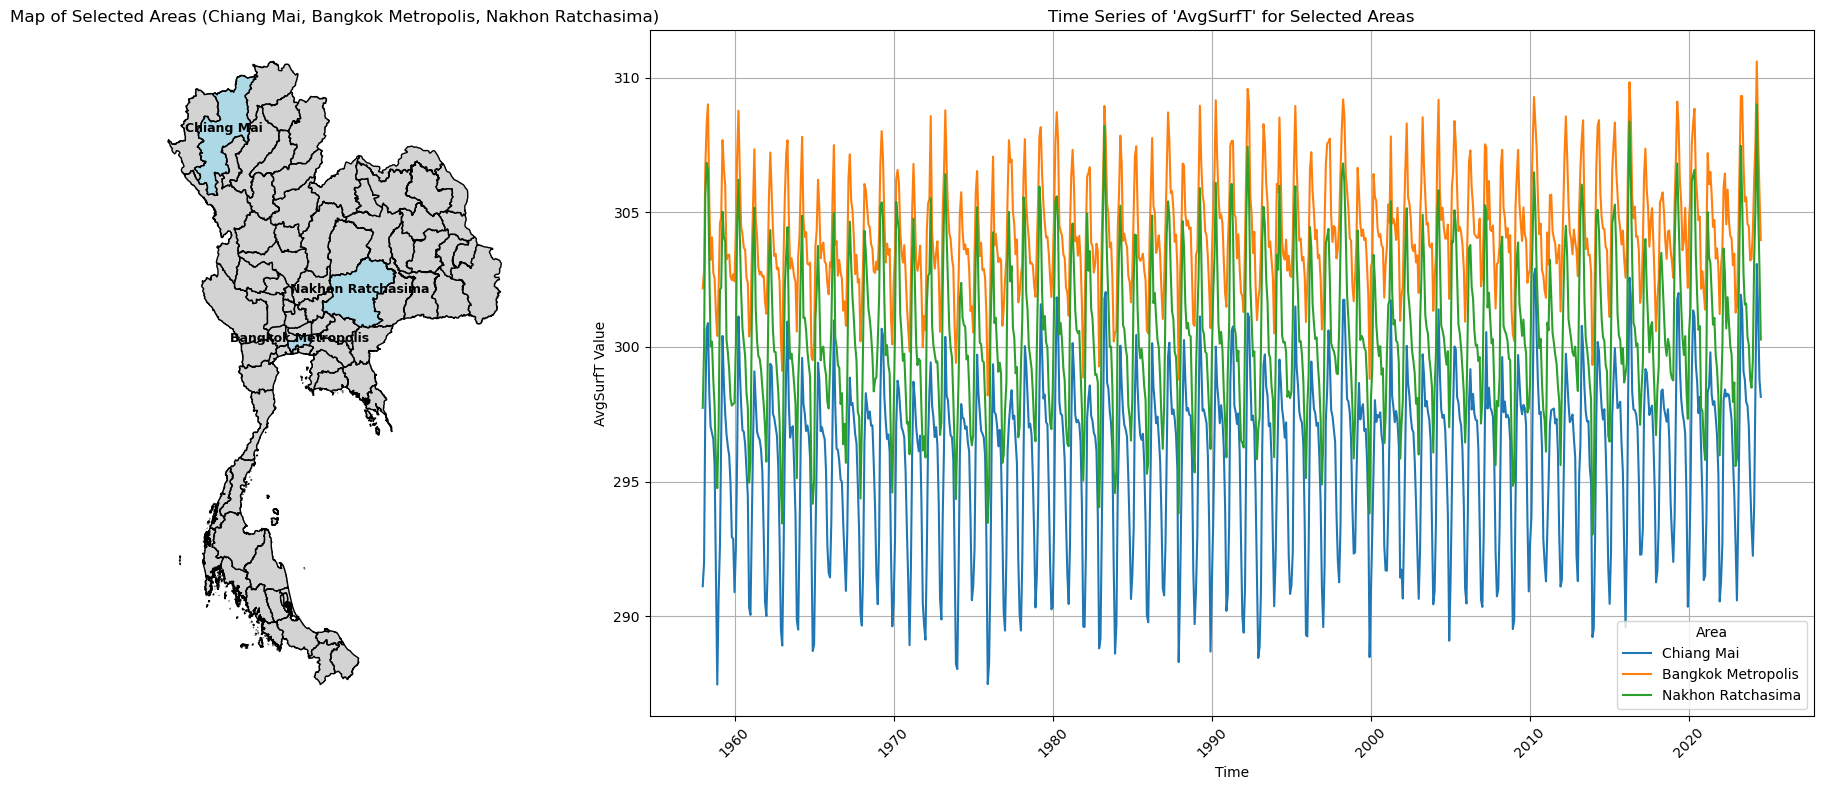

In [13]:
# Example call to the function
plot_map_variable_areas(
    data=dataset,  # Your xarray dataset
    variable='AvgSurfT',  # Example variable
    selected_areas=['Chiang Mai', 'Bangkok Metropolis', 'Nakhon Ratchasima'],  # List of selected areas
    gdf=gdf  # GeoDataFrame with geometries
)

In [15]:
def plot_map_mean(data, variable, shapefile_gdf, cmap='viridis', time_range=None, plot=True):
    """
    Plot a map of the mean values of a variable from the latest year in the dataset.

    Parameters:
    - data (xr.Dataset): The dataset containing variables and areas.
    - variable (str): The variable to plot (e.g., 'AvgSurfT').
    - shapefile_gdf (GeoDataFrame): GeoDataFrame containing the shapefile geometries with area names.
    - cmap (str): Colormap for visualization (default is 'viridis').

    Returns:
    - None (displays the plot)
    """
        # Subset the data for the specified time range
    if time_range:
        start_date, end_date = time_range
        data_var = data[variable].sel(time=slice(start_date, end_date))
    else:
        data_var = data[variable]
        
    # Convert the selected variable to a DataFrame
    data_var_df = data_var.to_pandas()

    # Calculate the mean for each area for the latest year
    mean_values = data_var_df.mean()

    # Create a mapping dictionary: area -> mean value
    area_mean_mapping = mean_values.to_dict()

    # Check the available areas in the shapefile
    shapefile_gdf = shapefile_gdf.copy()  # Avoid modifying the original GeoDataFrame
    shapefile_gdf['NAME_1'] = shapefile_gdf['NAME_1'].str.strip()

    # Merge the shapefile GeoDataFrame with the mean values
    shapefile_gdf['mean_value'] = shapefile_gdf['NAME_1'].map(area_mean_mapping)

    if plot:
        # Plotting the results
        fig, (ax_map, ax_ts) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 2]})
        # Plotting the map
        plt.figure(figsize=(15, 15))
        shapefile_gdf.plot(column='mean_value', 
                            cmap=cmap, 
                            linewidth=0.8, 
                            edgecolor='black', 
                            legend=True,
                            legend_kwds={'label': f'Mean {variable} for {time_range[0]} to {time_range[1]}', 'orientation': 'vertical'},
                            ax=ax_map)
        ax_map.set_title(f"Map of Mean {variable} ({time_range[0]} to {time_range[1]})")
        ax_map.axis('off')
            
        # Time series plot (SMI over time, averaged across areas)
        mean_over_time = data_var.mean(dim='area')
        mean_over_time.plot(ax=ax_ts, color='blue', label=f'Mean {variable}')
        ax_ts.set_title(f"{variable} Over Time ({time_range[0]} to {time_range[1]})")
        ax_ts.set_xlabel("Time")
        ax_ts.set_ylabel(f"{variable} Value")
        ax_ts.legend(loc='upper left')
        ax_ts.grid(True)
        
        plt.tight_layout()
        plt.show()

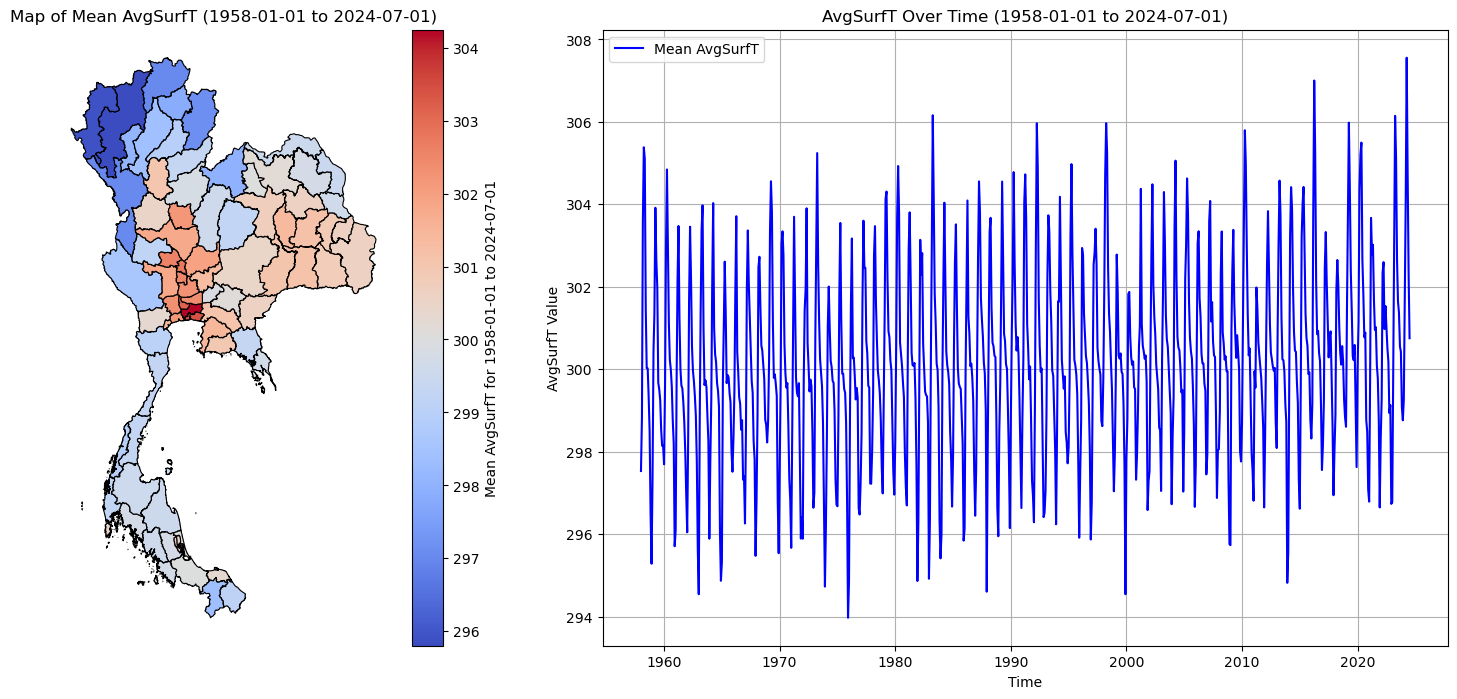

<Figure size 1500x1500 with 0 Axes>

In [21]:
# Example usage
plot_map_mean(data = dataset, variable = 'AvgSurfT', shapefile_gdf = gdf, cmap='coolwarm', 
              time_range=('1958-01-01', '2024-07-01'), plot=True)

In [65]:
dataset.data_vars

Data variables:
    AvgSurfT     (time, area) float64 499kB 299.3 296.1 298.4 ... 300.1 300.9
    EF           (time, area) float64 499kB 3.077 2.949 3.016 ... 4.378 10.66
    ESoil        (time, area) float64 499kB 3.494e-06 2.293e-06 ... 2.108e-05
    Evap         (time, area) float64 499kB 1.593e-05 1.455e-05 ... 3.763e-05
    GPP          (time, area) float64 499kB 2.882e-05 3.152e-05 ... 7.797e-05
    GWS          (time, area) float64 499kB 4.887e+03 4.888e+03 ... 4.903e+03
    LAI          (time, area) float64 499kB 1.139 1.55 2.57 ... 3.449 1.918
    Lwnet        (time, area) float64 499kB -70.23 -70.78 ... -47.44 -34.18
    NEE          (time, area) float64 499kB -9.976e-05 -8.403e-05 ... 5.704e-05
    NPP          (time, area) float64 499kB -1.732e-05 -1.657e-05 ... -3.896e-05
    Qg           (time, area) float64 499kB 1.014 0.5871 1.525 ... 0.5836 -2.735
    Qh           (time, area) float64 499kB 47.62 53.53 45.69 ... 23.56 8.307
    Qle          (time, area) float64 499kB 

In [3]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np

dataset['area'] = dataset['area'].str.strip()  # Remove extra spaces

shapefile_gdf = gdf.rename(columns={'NAME_1': 'area'})
shapefile_gdf['area'] = shapefile_gdf['area'].str.strip()

In [7]:
shapefile_gdf = shapefile_gdf.to_crs(epsg=3857)  # Convert to projected CRS for area calculation
shapefile_gdf['area_km2'] = shapefile_gdf.geometry.area / 1e6  # Convert area to square km
shapefile_gdf = shapefile_gdf.to_crs(epsg=4326)  # Convert back to geographic CRS for mapping
print(shapefile_gdf.head())

   ID_0  ISO    NAME_0  ID_1         area              VARNAME_1  \
0   218  THA  Thailand  2826     Chai Nat                Chainat   
1   218  THA  Thailand  2827   Chaiyaphum                   None   
2   218  THA  Thailand  2828  Chanthaburi  Chantaburi|Muang Chan   
3   218  THA  Thailand  2829   Chiang Mai                   None   
4   218  THA  Thailand  2830   Chiang Rai                   None   

          NL_NAME_1 HASC_1 CC_1    TYPE_1 ENGTYPE_1              VALIDFR_1  \
0     ?????????????  TH.CN   18  Changwat  Province  between 1915 and 1950   
1     ?????????????  TH.CY   36  Changwat  Province  between 1915 and 1950   
2          ????????  TH.CT   22  Changwat  Province  between 1915 and 1950   
3  ????????????????  TH.CM   50  Changwat  Province  between 1915 and 1950   
4   ???????????????  TH.CR   57  Changwat  Province               19770828   

  VALIDTO_1 REMARKS_1  Shape_Leng  Shape_Area  \
0   Present      None    2.503378    0.207364   
1   Present      None   

In [9]:
# Compute mean values per province (for initial map display)
def compute_mean(variable):
    return dataset[variable].mean(dim='time').to_pandas()

def create_geojson(variable):
    mean_values = compute_mean(variable)
    shapefile_gdf[variable] = shapefile_gdf['area'].map(mean_values)
    return shapefile_gdf

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Interactive ArcGIS Dashboard"),
    
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': var, 'value': var} for var in dataset.data_vars],
        value='AvgSurfT',
        clearable=False
    ),
    
    dcc.Graph(id='choropleth-map'),
    dcc.Graph(id='time-series-plot')
])

@app.callback(
    [Output('choropleth-map', 'figure'),
     Output('time-series-plot', 'figure')],
    [Input('variable-dropdown', 'value'),
     Input('choropleth-map', 'clickData')]
)
def update_dashboard(variable, clickData):
    geojson_gdf = create_geojson(variable)
    fig_map = px.choropleth(
        geojson_gdf, geojson=geojson_gdf.geometry, locations=geojson_gdf.index,
        color=variable, hover_name='area', color_continuous_scale='viridis'
    )
    fig_map.update_geos(fitbounds="locations")
    
    if clickData:
        selected_area = clickData['points'][0]['hovertext']
        ts_data = dataset[variable].sel(area=selected_area).to_pandas()
        title = f"{variable} Time Series for {selected_area}"
    else:
        ts_data = dataset[variable].mean(dim='area').to_pandas()
        title = f"{variable} National Time Series"
    
    fig_ts = px.line(ts_data, x=ts_data.index, y=ts_data.values, title=title)
    return fig_map, fig_ts

if __name__ == '__main__':
    app.run_server(debug=True)

In [61]:
# Compute mean values per province (for initial map display)
def compute_mean(variable, time=None):
    if time:
        return dataset[variable].sel(time=time).to_pandas()
    return dataset[variable].mean(dim='time').to_pandas()

def create_geojson(variable, time=None):
    mean_values = compute_mean(variable, time)
    shapefile_gdf[variable] = shapefile_gdf['area'].map(mean_values)
    return shapefile_gdf

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Interactive ArcGIS Dashboard"),
    
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': var, 'value': var} for var in dataset.data_vars],
        value='AvgSurfT',
        clearable=False
    ),
    
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': str(time.values), 'value': str(time.values)} for time in dataset.time],
        value=None,
        placeholder="Select a time (default: all time)"
    ),
    
    dcc.Graph(id='choropleth-map'),
    dcc.Graph(id='time-series-plot')
])

@app.callback(
    [Output('choropleth-map', 'figure'),
     Output('time-series-plot', 'figure')],
    [Input('variable-dropdown', 'value'),
     Input('time-dropdown', 'value'),
     Input('choropleth-map', 'clickData')]
)
def update_dashboard(variable, time, clickData):
    geojson_gdf = create_geojson(variable, time)
    fig_map = px.choropleth(
        geojson_gdf, geojson=geojson_gdf.geometry, locations=geojson_gdf.index,
        color=variable, hover_name='area', color_continuous_scale='viridis'
    )
    fig_map.update_geos(fitbounds="locations")
    
    if clickData:
        selected_area = clickData['points'][0]['hovertext']
        ts_data = dataset[variable].sel(area=selected_area).to_pandas()
        title = f"{variable} Time Series for {selected_area}"
    else:
        ts_data = dataset[variable].mean(dim='area').to_pandas()
        title = f"{variable} National Time Series"
    
    fig_ts = px.line(ts_data, x=ts_data.index, y=ts_data.values, title=title)
    return fig_map, fig_ts

if __name__ == '__main__':
    app.run_server(debug=True)


In [13]:
# Variable metadata mapping
variable_metadata = {
    "TWS": ("Terrestrial Water Storage", "mm", "jet_r"),
    "Swnet": ("Net Downward Shortwave Radiation", "W m-2", "plasma"),
    "Lwnet": ("Net Downward Longwave Radiation", "W m-2", "plasma"),
    "Qle": ("Latent Heat Flux", "W m-2", "plasma"),
    "Qh": ("Sensible Heat Flux", "W m-2", "plasma"),
    "Qg": ("Soil Heat Flux", "W m-2", "plasma"),
    "EF": ("Evaporative Fraction", "-", "jet"),
    "Evap": ("Total Evapotranspiration", "kg m-2 s-1", "jet"),
    "Qs": ("Surface Runoff", "kg m-2 s-1", "jet_r"),
    "Qsb": ("Subsurface Runoff", "kg m-2 s-1", "jet_r"),
    "AvgSurfT": ("Surface Temperature", "K", "jet"),
    "SoilMoist01": ("Soil Moisture Content 0-10 cm", "m3 m-3", "jet_r"),
    "SoilMoist02": ("Soil Moisture Content 10-40 cm", "m3 m-3", "jet_r"),
    "SoilMoist03": ("Soil Moisture Content 40-100 cm", "m3 m-3", "jet_r"),
    "SoilMoist04": ("Soil Moisture Content 100-200 cm", "m3 m-3", "jet_r"),
    "SoilTemp01": ("Soil Temperature 0-10 cm", "K", "jet"),
    "SoilTemp02": ("Soil Temperature 10-40 cm", "K", "jet"),
    "SoilTemp03": ("Soil Temperature 40-100 cm", "K", "jet"),
    "SoilTemp04": ("Soil Temperature 100-200 cm", "K", "jet"),
    "TVeg": ("Vegetation Transpiration", "kg m-2 s-1", "speed"),
    "ESoil": ("Bare Soil evaporation", "kg m-2 s-1", "jet"),
    "WaterTableD": ("Water Table Depth", "m", "jet_r"),
    "GWS": ("Ground Water Storage", "mm", "jet_r"),
    "GPP": ("Gross Primary Production", "g m-2 s-1", "speed"),
    "NPP": ("Net Primary Productivity", "g m-2 s-1", "speed"),
    "NEE": ("Net Ecosystem exchange", "g m-2 s-1", "speed"),
    "Rainf_f": ("Rainfall Flux", "mm/day", "jet_r"),
    "Tair_f": ("Air Temperature", "K", "jet"),
    "LAI": ("Leaf Area Index (LAI)", "m2 m-2", "speed")
}

def compute_mean(variable, time=None):
    if variable == "Rainf_f":
        data = dataset[variable] * 60 * 60 * 24
        return data.max(dim='time').to_pandas() if time is None else data.sel(time=time).to_pandas()
    return dataset[variable].mean(dim='time').to_pandas() if time is None else dataset[variable].sel(time=time).to_pandas()

def compute_stats(variable, area=None):
    if area:
        data = dataset[variable].sel(area=area).to_pandas()
    else:
        data = dataset[variable].mean(dim='area').to_pandas()
    
    return {
        "min": np.round(data.min(), 2),
        "mean": np.round(data.mean(), 2),
        "max": np.round(data.max(), 2),
        "std": np.round(data.std(), 2)
    }

def create_geojson(variable, time=None):
    mean_values = compute_mean(variable, time)
    shapefile_gdf[variable] = shapefile_gdf['area'].map(mean_values)
    return shapefile_gdf

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Interactive ArcGIS Dashboard"),
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': variable_metadata[var][0], 'value': var} for var in variable_metadata],
        value='AvgSurfT',
        clearable=False
    ),
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': str(time.values)[:10], 'value': str(time.values)[:10]} for time in dataset.time],
        value=None,
        placeholder="Select a time (default: all time)"
    ),
    dcc.Graph(id='choropleth-map'),
    dcc.Graph(id='time-series-plot')
])

@app.callback(
    [Output('choropleth-map', 'figure'),
     Output('time-series-plot', 'figure')],
    [Input('variable-dropdown', 'value'),
     Input('time-dropdown', 'value'),
     Input('choropleth-map', 'clickData')]
)
def update_dashboard(variable, time, clickData):
    label, unit, cmap = variable_metadata[variable]
    geojson_gdf = create_geojson(variable, time)
    fig_map = px.choropleth(
        geojson_gdf, geojson=geojson_gdf.geometry, locations=geojson_gdf.index,
        color=variable, hover_name='area', color_continuous_scale=cmap,
        labels={variable: f"{label} ({unit})"}
    )
    fig_map.update_geos(fitbounds="locations")
    
    if clickData:
        selected_area = clickData['points'][0]['hovertext']
        ts_data = dataset[variable].sel(area=selected_area).to_pandas()
        title = f"{label} Time Series for {selected_area}"
    else:
        ts_data = dataset[variable].mean(dim='area').to_pandas()
        title = f"{label} Thailand Time Series"
    
    fig_ts = px.line(ts_data, x=ts_data.index, y=ts_data.values, title=title, labels={"y": f"{label} ({unit})"})
    return fig_map, fig_ts

if __name__ == '__main__':
    app.run_server(debug=True)

In [15]:
shapefile_gdf['id'] = shapefile_gdf['area']  # Ensure unique ID column for mapping

# Variable metadata mapping
variable_metadata = {
    "TWS": ("Terrestrial Water Storage", "mm", "jet_r"),
    "Swnet": ("Net Downward Shortwave Radiation", "W m-2", "plasma"),
    "Lwnet": ("Net Downward Longwave Radiation", "W m-2", "plasma"),
    "Qle": ("Latent Heat Flux", "W m-2", "plasma"),
    "Qh": ("Sensible Heat Flux", "W m-2", "plasma"),
    "Qg": ("Soil Heat Flux", "W m-2", "plasma"),
    "EF": ("Evaporative Fraction", "-", "jet"),
    "Evap": ("Total Evapotranspiration", "kg m-2 s-1", "jet"),
    "Qs": ("Surface Runoff", "kg m-2 s-1", "jet_r"),
    "Qsb": ("Subsurface Runoff", "kg m-2 s-1", "jet_r"),
    "AvgSurfT": ("Surface Temperature", "K", "jet"),
    "SoilMoist01": ("Soil Moisture Content 0-10 cm", "m3 m-3", "jet_r"),
    "SoilMoist02": ("Soil Moisture Content 10-40 cm", "m3 m-3", "jet_r"),
    "SoilMoist03": ("Soil Moisture Content 40-100 cm", "m3 m-3", "jet_r"),
    "SoilMoist04": ("Soil Moisture Content 100-200 cm", "m3 m-3", "jet_r"),
    "SoilTemp01": ("Soil Temperature 0-10 cm", "K", "jet"),
    "SoilTemp02": ("Soil Temperature 10-40 cm", "K", "jet"),
    "SoilTemp03": ("Soil Temperature 40-100 cm", "K", "jet"),
    "SoilTemp04": ("Soil Temperature 100-200 cm", "K", "jet"),
    "TVeg": ("Vegetation Transpiration", "kg m-2 s-1", "speed"),
    "ESoil": ("Bare Soil evaporation", "kg m-2 s-1", "jet"),
    "WaterTableD": ("Water Table Depth", "m", "jet_r"),
    "GWS": ("Ground Water Storage", "mm", "jet_r"),
    "GPP": ("Gross Primary Production", "g m-2 s-1", "speed"),
    "NPP": ("Net Primary Productivity", "g m-2 s-1", "speed"),
    "NEE": ("Net Ecosystem exchange", "g m-2 s-1", "speed"),
    "Rainf_f": ("Rainfall Flux", "mm/day", "jet_r"),
    "Tair_f": ("Air Temperature", "K", "jet"),
    "LAI": ("Leaf Area Index (LAI)", "m2 m-2", "speed")
}

def compute_mean(variable, time=None):
    if variable == "Rainf_f":
        data = dataset[variable] * 60 * 60 * 24
        return data.max(dim='time').to_pandas() if time is None else data.sel(time=time).to_pandas()
    return dataset[variable].mean(dim='time').to_pandas() if time is None else dataset[variable].sel(time=time).to_pandas()

def compute_stats(variable, area=None):
    if area:
        data = dataset[variable].sel(area=area).to_pandas()
    else:
        data = dataset[variable].mean(dim='area').to_pandas()
    
    return {
        "min": np.round(data.min(), 2),
        "mean": np.round(data.mean(), 2),
        "max": np.round(data.max(), 2),
        "std": np.round(data.std(), 2)
    }

def create_geojson(variable, time=None):
    mean_values = compute_mean(variable, time)
    shapefile_gdf[variable] = shapefile_gdf['area'].map(mean_values)
    geojson = json.loads(shapefile_gdf.to_json())
    for feature in geojson["features"]:
        feature["properties"]["id"] = feature["properties"]["area"]
    return geojson

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Interactive ArcGIS Dashboard"),
    html.Div([
        html.Div([
            html.H4("Statistics & Area"),
            html.P(id='area-info', children="Country Area"),
            html.P(id='stats-info', children="Min: -, Mean: -, Max: -, Std: -"),
            dcc.Graph(id='province-map', style={'display': 'none'}),
            dcc.Graph(id='province-time-series', style={'display': 'none'})
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '20px', 'verticalAlign': 'top', 'backgroundColor': '#f9f9f9', 'color': '#333', 'borderRadius': '5px', 'boxShadow': '2px 2px 5px rgba(0, 0, 0, 0.1)'}),
        html.Div([
            dcc.Dropdown(
                id='variable-dropdown',
                options=[{'label': variable_metadata[var][0], 'value': var} for var in variable_metadata],
                value='AvgSurfT',
                clearable=False
            ),
            dcc.Dropdown(
                id='time-dropdown',
                options=[{'label': str(time.values)[:10], 'value': str(time.values)[:10]} for time in dataset.time],
                value=None,
                placeholder="Select a time (default: all time)"
            ),
            dcc.Graph(id='choropleth-map'),
            dcc.Graph(id='time-series-plot')
        ], style={'width': '70%', 'display': 'inline-block'}),
    ], style={'display': 'flex'}),
])

@app.callback(
    [Output('choropleth-map', 'figure'),
     Output('time-series-plot', 'figure'),
     Output('province-time-series', 'figure'),
     Output('province-time-series', 'style'),
     Output('area-info', 'children'),
     Output('stats-info', 'children')],
    [Input('variable-dropdown', 'value'),
     Input('time-dropdown', 'value'),
     Input('choropleth-map', 'clickData')]
)

def update_dashboard(variable, time, clickData):
    label, unit, cmap = variable_metadata[variable]
    geojson_gdf = create_geojson(variable)
    
    fig_map = px.choropleth(
        shapefile_gdf, geojson=geojson_gdf, locations='id', featureidkey="properties.id",
        color=variable, hover_name='area', color_continuous_scale=cmap,
        labels={variable: f"{label} ({unit})"}
    )
    fig_map.update_geos(fitbounds="locations", visible=False)
    
    if time:
        ts_data = dataset[variable].sel(time=time).mean(dim='area').to_pandas()
    else:
        ts_data = dataset[variable].mean(dim='area').to_pandas()
    fig_ts = px.line(ts_data, x=ts_data.index, y=ts_data.values, title=f"{label} Thailand Time Series", labels={"y": f"{label} ({unit})"})
    
    if clickData and 'points' in clickData and len(clickData['points']) > 0:
        selected_area = clickData['points'][0].get('location', None)
        if selected_area:
            stats = compute_stats(variable, selected_area)
            area_km2 = shapefile_gdf.loc[shapefile_gdf['area'] == selected_area, 'area_km2'].values[0]
            ts_province = dataset[variable].sel(area=selected_area).to_pandas()
            fig_province_ts = px.line(ts_province, x=ts_province.index, y=ts_province.values, title=f"{label} Time Series for {selected_area}")
            return fig_map, fig_ts, fig_province_ts, {'display': 'block'}, f"Selected Area: {selected_area} ({area_km2:.2f} km²)", f"Min: {stats['min']}, Mean: {stats['mean']}, Max: {stats['max']}, Std: {stats['std']}"
    
    return fig_map, fig_ts, {}, {'display': 'none'}, "Country Area", "Min: -, Mean: -, Max: -, Std: -"

if __name__ == '__main__':
    app.run_server(debug=True)

In [13]:
str(dataset.time[0].values)[:10]

'1958-01-01'

In [61]:
shapefile_gdf

,ID_0,ISO,NAME_0,ID_1,area,VARNAME_1,NL_NAME_1,HASC_1,CC_1,TYPE_1,ENGTYPE_1,VALIDFR_1,VALIDTO_1,REMARKS_1,Shape_Leng,Shape_Area,geometry,area_km2,AvgSurfT
0,218,THA,Thailand,2826,Chai Nat,Chainat,?????????????,TH.CN,18,Changwat,Province,between 1915 and 1950,Present,None,2.503378,0.207364,"POLYGON ((100.11601 15.41157, 100.11974 15.410...",2661.960887,302.565575
1,218,THA,Thailand,2827,Chaiyaphum,None,?????????????,TH.CY,36,Changwat,Province,between 1915 and 1950,Present,None,6.393654,1.069534,"POLYGON ((101.57202 16.72447, 101.57427 16.724...",13790.164415,299.258899
2,218,THA,Thailand,2828,Chanthaburi,Chantaburi|Muang Chan,????????,TH.CT,22,Changwat,Province,between 1915 and 1950,Present,None,7.068561,0.521939,"MULTIPOLYGON (((102.25305 12.28667, 102.25166 ...",6634.960121,299.322466
3,218,THA,Thailand,2829,Chiang Mai,None,????????????????,TH.CM,50,Changwat,Province,between 1915 and 1950,Present,None,12.403438,1.894280,"POLYGON ((99.5204 20.13689, 99.52489 20.13484,...",24797.474946,295.802569
4,218,THA,Thailand,2830,Chiang Rai,None,???????????????,TH.CR,57,Changwat,Province,19770828,Present,None,6.499079,0.998244,"POLYGON ((99.96197 20.46282, 99.96226 20.46238...",13151.541060,297.035217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,218,THA,Thailand,2894,Udon Thani,None,???????????????,TH.UN,41,Changwat,Province,1993,Present,None,8.846678,0.940520,"POLYGON ((102.08277 18.05941, 102.08304 18.059...",12215.631696,300.191197
74,218,THA,Thailand,2895,Uthai Thani,None,????????????????,TH.UT,61,Changwat,Province,between 1915 and 1950,Present,None,4.592463,0.560634,"POLYGON ((99.15148 15.79116, 99.15411 15.79112...",7204.402569,299.177395
75,218,THA,Thailand,2896,Uttaradit,None,????????????????,TH.UD,53,Changwat,Province,between 1915 and 1950,Present,None,5.334107,0.664635,"POLYGON ((101.09907 18.37826, 101.09968 18.377...",8647.820064,299.299183
76,218,THA,Thailand,2897,Yala,None,???????????,TH.YL,95,Changwat,Province,between 1915 and 1950,Present,None,4.476266,0.362138,"POLYGON ((101.29746 6.67563, 101.29733 6.67495...",4514.024064,298.373293
